In [24]:
# import GPy
import time
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
# from google.colab import files
import PIL
%config InlineBackend.figure_format = 'svg'
import tqdm

In [25]:
# help("modules")

In [26]:
# torch.cuda.device(0)
device=torch.device("cuda:2")

In [27]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:

        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.to(device)

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [28]:
# @pysnooper.snop

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2   #exponent is negative term
    
    log_coeff = -no_dim*torch.log(sigma)  #sigma here means exp(sigma), so log_coeff=sigma.
#    
#     print(exponent.sum(),log_coeff*len(exponent))
    
    return - ( exponent+log_coeff).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) +2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [29]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (1/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):

        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [88]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer

        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0,1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
        self.log_noise = nn.Parameter(torch.FloatTensor([init_log_noise]))


    
    def forward(self, x):
        

        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)

        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [92]:
s1=1
s2=1
s3=1
rho1=1
rho2=1
rho3=1
from IPython.core.debugger import set_trace
class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise):
        


        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.to(device)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr =self.learn_rate)
        self.loss_func = log_gaussian_loss

    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        KL_loss_total=0
        c_loss=torch.zeros(no_samples, 1)
        x_point=torch.linspace(0.08,1.0,50).to(device)
        c1= torch.zeros(no_samples).to(device)
        c2= torch.zeros(no_samples).to(device)
        c3= torch.zeros(no_samples).to(device)

        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            sample_output,_=self.network(x_point)
            diff_vector=torch.diff(sample_output,dim=0)+1e-6
            diff_vector[diff_vector>0]=1e-8
            diff1=fun_UB(x_point).unsqueeze(1).to(device)-sample_output  #ub
            diff1[diff1>0]=1e-8
            diff2=sample_output-torch.FloatTensor(constant_function(0)(x_point)).unsqueeze(1).to(device)#lb
            diff2[diff2>0]=1e-8
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
            c1[i]=torch.mean(diff_vector)
            c2[i]=torch.mean(diff1)
            c3[i]=torch.mean(diff2)
        c1_mean=c1.mean()
        c2_mean=c2.mean()
        c3_mean=c3.mean()
        c1_loss=-0.5*s1**2/(rho1+1e-8)+0.5*rho1*((c1_mean-s1/rho1)**2)*(rho1*c1_mean<=s1)
        c2_loss=-0.5*s2**2/(rho2+1e-8)+0.5*rho2*((c2_mean-s2/rho2)**2)*(rho2*c2_mean<=s2)
        c3_loss=-0.5*s3**2/(rho3+1e-8)+0.5*rho3*((c3_mean-s1/rho3)**2)*(rho3*c3_mean<=s3)   

        
        KL_loss_avg = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total+KL_loss_avg )/(no_samples*x.shape[0])+c1_loss+c2_loss+c3_loss
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total,c1_mean,c2_mean,c3_mean,c1_loss,c2_loss,c3_loss

# Generate data


In [93]:
torch.random.seed()
no_points = 300
lengthscale = 1
variance = 1.0
sig_noise = 0.1
def fun(x):
    return (np.arctan(20*x - 10) - np.arctan(-10))/3        
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return torch.zeros(x.shape[0])+val
    
    return fun

def fun_UB(x):
    """ Upper bound function """
    return torch.log(25*x.flatten() + 1)/3+0.05      



x_test = np.linspace(0.08, 1, 100)
y_true = fun(x_test)

n = 100
noise_std = 0.1
np.random.seed(1)
x_design = np.random.uniform(0.1, 0.65, n)
x_design.sort(axis = 0)
np.random.seed(10)
y_design = fun(x_design) + np.random.normal(0, noise_std, n)

positive_index=np.where(y_design>=0)[0]
x_design=x_design[positive_index]
y_design=y_design[positive_index]
# diff_y=np.diff(y_design)
# print(diff_y)
# mono_index=(np.where(diff_y<1e-8))[0]+1
train=np.stack((x_design,y_design),axis=-1)
np.random.shuffle(train)

x_mean, x_std = x_design.mean(), x_design.var()**0.5
y_mean, y_std = y_design.mean(), y_design.var()**0.5
x_train=  torch.FloatTensor(x_design[:,np.newaxis])      
y_train=  torch.FloatTensor(y_design[:,np.newaxis])      
x_test=  torch.FloatTensor(x_test)      
y_true=  torch.FloatTensor(y_true)   
print(x_mean, x_std,y_mean, y_std)


sigma=0.1

ntrain=n

0.39002997648690874 0.15905669404006317 0.330080644951817 0.31368231521073986


In [94]:

num_epochs, batch_size, nb_train = 6000, len(x_train), len(x_train)
net = BBP_Homoscedastic_Model_Wrapper(input_dim = 1, output_dim = 1, no_units = 100, learn_rate =0.005,
                                      batch_size = batch_size, no_batches = 1, init_log_noise = 0)

constraint_loss=np.zeros(num_epochs)
fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
all_loss = np.zeros(num_epochs)
c1_m=np.zeros(num_epochs)
c2_m=np.zeros(num_epochs)
c3_m=np.zeros(num_epochs)
best_net, best_loss = None, float('inf')


for i in range(num_epochs):
    rho1=rho1
    rho2=rho2
    rho3=rho3
    fit_loss, KL_loss,c1_avg,c2_avg,c3_avg,phi1,phi2,phi3 = net.fit(x_train, y_train, no_samples = 5)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    c1_m[i]=c1_avg.cpu().data.numpy()
    c2_m[i]=c2_avg.cpu().data.numpy()
    c3_m[i]=c3_avg.cpu().data.numpy()
    s1=torch.max(torch.tensor(0.),s1-rho1*torch.tensor(c1_avg.clone()))     
    s2=torch.max(torch.tensor(0.),s2-rho2*torch.tensor(c2_avg.clone()))
    s3=torch.max(torch.tensor(0.),s3-rho3*torch.tensor(c3_avg.clone()))
    all_loss[i] = fit_loss_train[i] + KL_loss_train[i]+c1_m[i]+c2_m[i]+c3_m[i]
    loss_compare= fit_loss
    if loss_compare< best_loss:
        best_loss = loss_compare
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, c1 Loss =%8.3f,s1 =%8.3f,c2 Loss =%8.3f,s2 =%8.3f,c3 Loss =%8.3f, s3 =%8.3f,noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i],c1_avg,s1,c2_avg,s2,c3_avg,s3, net.network.log_noise.exp().cpu().data.numpy()))

/env/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/env/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/env/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:     1/ 6000, Fit loss =   12.205, KL loss =  339.965, c1 Loss =  -0.001,s1 =   1.001,c2 Loss =   0.000,s2 =   1.000,c3 Loss =  -0.122, s3 =   1.122,noise =  0.995


Epoch:   101/ 6000, Fit loss =  -28.867, KL loss =  325.474, c1 Loss =  -0.001,s1 =   1.111,c2 Loss =  -0.125,s2 =   3.144,c3 Loss =  -0.017, s3 =   3.874,noise =  0.619


Epoch:   201/ 6000, Fit loss =  -53.085, KL loss =  315.051, c1 Loss =  -0.000,s1 =   1.165,c2 Loss =   0.000,s2 =   3.519,c3 Loss =   0.000, s3 =   4.701,noise =  0.424


Epoch:   301/ 6000, Fit loss =  -63.673, KL loss =  310.257, c1 Loss =   0.000,s1 =   1.187,c2 Loss =  -0.004,s2 =   3.924,c3 Loss =  -0.000, s3 =   5.188,noise =  0.330


Epoch:   401/ 6000, Fit loss =  -80.475, KL loss =  307.077, c1 Loss =  -0.000,s1 =   1.195,c2 Loss =  -0.003,s2 =   4.572,c3 Loss =   0.000, s3 =   5.308,noise =  0.281


Epoch:   501/ 6000, Fit loss =  -82.277, KL loss =  305.759, c1 Loss =   0.000,s1 =   1.200,c2 Loss =  -0.008,s2 =   5.389,c3 Loss =  -0.000, s3 =   5.377,noise =  0.246


Epoch:   601/ 6000, Fit loss =  -92.295, KL loss =  304.190, c1 Loss =  -0.000,s1 =   1.205,c2 Loss =  -0.040,s2 =   6.231,c3 Loss =  -0.000, s3 =   5.445,noise =  0.217


Epoch:   701/ 6000, Fit loss = -100.525, KL loss =  301.570, c1 Loss =  -0.000,s1 =   1.213,c2 Loss =  -0.001,s2 =   6.902,c3 Loss =   0.000, s3 =   5.497,noise =  0.198


Epoch:   801/ 6000, Fit loss = -109.135, KL loss =  296.204, c1 Loss =  -0.000,s1 =   1.224,c2 Loss =  -0.003,s2 =   7.606,c3 Loss =   0.000, s3 =   5.524,noise =  0.179


Epoch:   901/ 6000, Fit loss = -101.599, KL loss =  291.437, c1 Loss =  -0.000,s1 =   1.235,c2 Loss =  -0.003,s2 =   8.430,c3 Loss =   0.000, s3 =   5.539,noise =  0.171


Epoch:  1001/ 6000, Fit loss = -103.522, KL loss =  286.218, c1 Loss =  -0.000,s1 =   1.245,c2 Loss =  -0.005,s2 =   9.124,c3 Loss =   0.000, s3 =   5.542,noise =  0.168


Epoch:  1101/ 6000, Fit loss = -115.536, KL loss =  278.474, c1 Loss =  -0.000,s1 =   1.254,c2 Loss =  -0.002,s2 =   9.783,c3 Loss =   0.000, s3 =   5.545,noise =  0.165


Epoch:  1201/ 6000, Fit loss = -115.904, KL loss =  274.577, c1 Loss =   0.000,s1 =   1.260,c2 Loss =  -0.009,s2 =  10.330,c3 Loss =   0.000, s3 =   5.589,noise =  0.166


Epoch:  1301/ 6000, Fit loss = -120.056, KL loss =  269.428, c1 Loss =  -0.000,s1 =   1.267,c2 Loss =  -0.002,s2 =  10.834,c3 Loss =   0.000, s3 =   5.600,noise =  0.163


Epoch:  1401/ 6000, Fit loss = -121.189, KL loss =  266.513, c1 Loss =  -0.000,s1 =   1.273,c2 Loss =   0.000,s2 =  11.333,c3 Loss =   0.000, s3 =   5.616,noise =  0.151


Epoch:  1501/ 6000, Fit loss = -141.217, KL loss =  264.888, c1 Loss =   0.000,s1 =   1.280,c2 Loss =  -0.000,s2 =  11.555,c3 Loss =   0.000, s3 =   5.657,noise =  0.127


Epoch:  1601/ 6000, Fit loss = -154.240, KL loss =  261.666, c1 Loss =   0.000,s1 =   1.288,c2 Loss =  -0.000,s2 =  11.737,c3 Loss =   0.000, s3 =   5.687,noise =  0.109


Epoch:  1701/ 6000, Fit loss = -155.367, KL loss =  260.015, c1 Loss =  -0.000,s1 =   1.299,c2 Loss =   0.000,s2 =  11.864,c3 Loss =   0.000, s3 =   5.693,noise =  0.102


Epoch:  1801/ 6000, Fit loss = -150.930, KL loss =  255.774, c1 Loss =  -0.000,s1 =   1.319,c2 Loss =   0.000,s2 =  11.923,c3 Loss =   0.000, s3 =   5.705,noise =  0.099


Epoch:  1901/ 6000, Fit loss = -158.265, KL loss =  255.238, c1 Loss =  -0.001,s1 =   1.359,c2 Loss =   0.000,s2 =  12.037,c3 Loss =   0.000, s3 =   5.711,noise =  0.099


Epoch:  2001/ 6000, Fit loss = -162.744, KL loss =  252.418, c1 Loss =  -0.001,s1 =   1.443,c2 Loss =   0.000,s2 =  12.112,c3 Loss =   0.000, s3 =   5.739,noise =  0.096


Epoch:  2101/ 6000, Fit loss = -161.439, KL loss =  248.931, c1 Loss =  -0.000,s1 =   1.496,c2 Loss =  -0.000,s2 =  12.154,c3 Loss =   0.000, s3 =   5.746,noise =  0.100


Epoch:  2201/ 6000, Fit loss = -162.203, KL loss =  246.520, c1 Loss =  -0.001,s1 =   1.567,c2 Loss =   0.000,s2 =  12.197,c3 Loss =   0.000, s3 =   5.748,noise =  0.096


Epoch:  2301/ 6000, Fit loss = -161.890, KL loss =  244.716, c1 Loss =  -0.003,s1 =   1.646,c2 Loss =   0.000,s2 =  12.243,c3 Loss =   0.000, s3 =   5.766,noise =  0.100


Epoch:  2401/ 6000, Fit loss = -147.552, KL loss =  241.972, c1 Loss =  -0.001,s1 =   1.740,c2 Loss =   0.000,s2 =  12.277,c3 Loss =   0.000, s3 =   5.805,noise =  0.098


Epoch:  2501/ 6000, Fit loss = -159.042, KL loss =  239.047, c1 Loss =  -0.001,s1 =   1.841,c2 Loss =  -0.003,s2 =  12.319,c3 Loss =   0.000, s3 =   5.860,noise =  0.096


Epoch:  2601/ 6000, Fit loss = -161.973, KL loss =  238.489, c1 Loss =  -0.001,s1 =   1.974,c2 Loss =   0.000,s2 =  12.359,c3 Loss =   0.000, s3 =   5.865,noise =  0.097


Epoch:  2701/ 6000, Fit loss = -161.898, KL loss =  238.667, c1 Loss =  -0.000,s1 =   2.085,c2 Loss =   0.000,s2 =  12.407,c3 Loss =   0.000, s3 =   5.871,noise =  0.095


Epoch:  2801/ 6000, Fit loss = -162.168, KL loss =  237.132, c1 Loss =  -0.002,s1 =   2.187,c2 Loss =  -0.006,s2 =  12.433,c3 Loss =   0.000, s3 =   5.871,noise =  0.097


Epoch:  2901/ 6000, Fit loss = -163.113, KL loss =  236.637, c1 Loss =  -0.002,s1 =   2.329,c2 Loss =   0.000,s2 =  12.523,c3 Loss =   0.000, s3 =   5.911,noise =  0.095


Epoch:  3001/ 6000, Fit loss = -162.444, KL loss =  236.087, c1 Loss =  -0.001,s1 =   2.478,c2 Loss =   0.000,s2 =  12.553,c3 Loss =   0.000, s3 =   5.915,noise =  0.095


Epoch:  3101/ 6000, Fit loss = -162.981, KL loss =  233.954, c1 Loss =  -0.001,s1 =   2.563,c2 Loss =   0.000,s2 =  12.580,c3 Loss =   0.000, s3 =   5.915,noise =  0.095


Epoch:  3201/ 6000, Fit loss = -162.823, KL loss =  233.120, c1 Loss =  -0.001,s1 =   2.651,c2 Loss =   0.000,s2 =  12.621,c3 Loss =   0.000, s3 =   5.926,noise =  0.094


Epoch:  3301/ 6000, Fit loss = -162.764, KL loss =  230.078, c1 Loss =  -0.001,s1 =   2.738,c2 Loss =   0.000,s2 =  12.677,c3 Loss =   0.000, s3 =   5.926,noise =  0.100


Epoch:  3401/ 6000, Fit loss = -162.471, KL loss =  229.169, c1 Loss =  -0.001,s1 =   2.834,c2 Loss =   0.000,s2 =  12.803,c3 Loss =   0.000, s3 =   5.928,noise =  0.095


Epoch:  3501/ 6000, Fit loss = -162.251, KL loss =  230.117, c1 Loss =  -0.000,s1 =   2.914,c2 Loss =   0.000,s2 =  12.911,c3 Loss =   0.000, s3 =   5.935,noise =  0.102


Epoch:  3601/ 6000, Fit loss = -161.650, KL loss =  230.068, c1 Loss =  -0.001,s1 =   2.992,c2 Loss =   0.000,s2 =  13.004,c3 Loss =   0.000, s3 =   5.938,noise =  0.106


Epoch:  3701/ 6000, Fit loss = -162.219, KL loss =  230.804, c1 Loss =  -0.000,s1 =   3.057,c2 Loss =   0.000,s2 =  13.089,c3 Loss =   0.000, s3 =   5.938,noise =  0.096


Epoch:  3801/ 6000, Fit loss = -162.379, KL loss =  230.883, c1 Loss =  -0.001,s1 =   3.161,c2 Loss =   0.000,s2 =  13.148,c3 Loss =   0.000, s3 =   5.938,noise =  0.096


Epoch:  3901/ 6000, Fit loss = -162.027, KL loss =  228.726, c1 Loss =  -0.001,s1 =   3.237,c2 Loss =  -0.000,s2 =  13.172,c3 Loss =   0.000, s3 =   5.952,noise =  0.094


Epoch:  4001/ 6000, Fit loss = -157.050, KL loss =  225.197, c1 Loss =  -0.000,s1 =   3.284,c2 Loss =   0.000,s2 =  13.183,c3 Loss =   0.000, s3 =   5.956,noise =  0.094


Epoch:  4101/ 6000, Fit loss = -163.095, KL loss =  226.189, c1 Loss =  -0.001,s1 =   3.363,c2 Loss =   0.000,s2 =  13.271,c3 Loss =   0.000, s3 =   5.973,noise =  0.096


Epoch:  4201/ 6000, Fit loss = -162.299, KL loss =  226.869, c1 Loss =  -0.001,s1 =   3.455,c2 Loss =   0.000,s2 =  13.347,c3 Loss =   0.000, s3 =   6.114,noise =  0.096


Epoch:  4301/ 6000, Fit loss = -153.501, KL loss =  226.026, c1 Loss =  -0.000,s1 =   3.518,c2 Loss =   0.000,s2 =  13.364,c3 Loss =   0.000, s3 =   6.123,noise =  0.095


Epoch:  4401/ 6000, Fit loss = -162.321, KL loss =  227.668, c1 Loss =  -0.001,s1 =   3.567,c2 Loss =   0.000,s2 =  13.390,c3 Loss =   0.000, s3 =   6.133,noise =  0.097


Epoch:  4501/ 6000, Fit loss = -159.759, KL loss =  227.802, c1 Loss =  -0.001,s1 =   3.629,c2 Loss =   0.000,s2 =  13.481,c3 Loss =   0.000, s3 =   6.157,noise =  0.096


Epoch:  4601/ 6000, Fit loss = -162.685, KL loss =  227.275, c1 Loss =  -0.000,s1 =   3.679,c2 Loss =   0.000,s2 =  13.491,c3 Loss =   0.000, s3 =   6.167,noise =  0.095


Epoch:  4701/ 6000, Fit loss = -162.787, KL loss =  227.708, c1 Loss =  -0.001,s1 =   3.722,c2 Loss =   0.000,s2 =  13.558,c3 Loss =   0.000, s3 =   6.170,noise =  0.095


Epoch:  4801/ 6000, Fit loss = -161.600, KL loss =  227.457, c1 Loss =  -0.001,s1 =   3.760,c2 Loss =   0.000,s2 =  13.652,c3 Loss =   0.000, s3 =   6.194,noise =  0.095


Epoch:  4901/ 6000, Fit loss = -161.877, KL loss =  227.763, c1 Loss =  -0.000,s1 =   3.810,c2 Loss =   0.000,s2 =  13.669,c3 Loss =   0.000, s3 =   6.207,noise =  0.095


Epoch:  5001/ 6000, Fit loss = -162.279, KL loss =  225.986, c1 Loss =  -0.001,s1 =   3.860,c2 Loss =  -0.006,s2 =  13.714,c3 Loss =   0.000, s3 =   6.215,noise =  0.094


Epoch:  5101/ 6000, Fit loss = -156.311, KL loss =  225.675, c1 Loss =  -0.000,s1 =   3.919,c2 Loss =   0.000,s2 =  13.792,c3 Loss =   0.000, s3 =   6.233,noise =  0.094


Epoch:  5201/ 6000, Fit loss = -162.202, KL loss =  225.382, c1 Loss =  -0.000,s1 =   3.958,c2 Loss =   0.000,s2 =  13.838,c3 Loss =   0.000, s3 =   6.235,noise =  0.095


Epoch:  5301/ 6000, Fit loss = -161.699, KL loss =  223.524, c1 Loss =  -0.000,s1 =   4.005,c2 Loss =   0.000,s2 =  13.939,c3 Loss =   0.000, s3 =   6.251,noise =  0.096


Epoch:  5401/ 6000, Fit loss = -163.168, KL loss =  223.903, c1 Loss =  -0.000,s1 =   4.058,c2 Loss =   0.000,s2 =  13.977,c3 Loss =   0.000, s3 =   6.253,noise =  0.097


Epoch:  5501/ 6000, Fit loss = -162.310, KL loss =  222.846, c1 Loss =  -0.000,s1 =   4.096,c2 Loss =  -0.003,s2 =  14.004,c3 Loss =   0.000, s3 =   6.256,noise =  0.095


Epoch:  5601/ 6000, Fit loss = -162.986, KL loss =  221.923, c1 Loss =  -0.000,s1 =   4.135,c2 Loss =   0.000,s2 =  14.081,c3 Loss =   0.000, s3 =   6.269,noise =  0.094


Epoch:  5701/ 6000, Fit loss = -162.459, KL loss =  223.216, c1 Loss =  -0.001,s1 =   4.197,c2 Loss =   0.000,s2 =  14.154,c3 Loss =   0.000, s3 =   6.333,noise =  0.095


Epoch:  5801/ 6000, Fit loss = -160.019, KL loss =  224.392, c1 Loss =  -0.000,s1 =   4.251,c2 Loss =   0.000,s2 =  14.267,c3 Loss =   0.000, s3 =   6.388,noise =  0.100


Epoch:  5901/ 6000, Fit loss = -162.998, KL loss =  223.442, c1 Loss =  -0.000,s1 =   4.319,c2 Loss =   0.000,s2 =  14.336,c3 Loss =   0.000, s3 =   6.412,noise =  0.095


Epoch:  6000/ 6000, Fit loss = -155.286, KL loss =  225.670, c1 Loss =  -0.000,s1 =   4.360,c2 Loss =   0.000,s2 =  14.414,c3 Loss =   0.000, s3 =   6.412,noise =  0.104


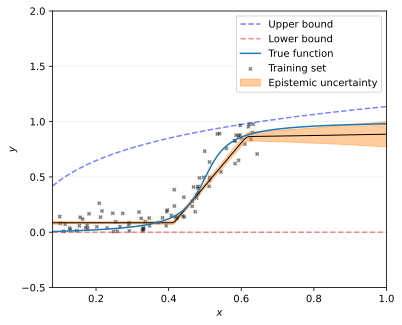

In [95]:
y_up=fun_UB(torch.linspace(0.08, 1, 200))
x_test=torch.linspace(0.08, 1, 200)
samples = []
for i in range(500):
    preds = (net.network.forward(torch.linspace(0.05, 1, 200).to(device))[0] ) 
    samples.append(preds.cpu().data.numpy()[:, 0])

samples = np.array(samples)
means = samples.mean(axis = 0)

aleatoric = net.network.log_noise.exp().cpu().data.numpy()
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# ax =sns.lineplot(X_test.numpy(),y_lb.numpy())

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train , y_train , s = 10, marker = 'x', color = 'black', alpha = 0.5,label='Training set')
# plt.fill_between(np.linspace(0, 1, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic uncentainty')
# plt.fill_between(np.linspace(0, 1, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(0.08, 1, 200), means - epistemic, means + epistemic, color = c[1], alpha = 0.4, label = 'Epistemic uncertainty')
plt.plot(np.linspace(0.08, 1, 200), means, color = 'black', linewidth = 1)
plt.plot(x_test.numpy(),y_up.numpy(),color='blue', linestyle='--',alpha=0.5,label='Upper bound')
plt.axhline(y=0., color=c[3], linestyle='--',alpha=0.5,label='Lower bound')
plt.plot(x_test.numpy(),fun(x_test.numpy()),label='True function')


plt.xlim([0.08, 1])
plt.ylim([-0.5,2])
plt.xlabel('$x$', fontsize=10)
plt.ylabel('$y$', fontsize=10)

# plt.title('With Hard Constraints', fontsize=10)
plt.tick_params(labelsize=10)
# plt.xticks(np.arange(-4, 5, 2))
plt.gca().yaxis.grid(alpha=0.2)
plt.legend()
# plt.gca().xaxis.grid(alpha=0.3)
# plt.savefig('bbp_homo.pdf', bbox_inches = 'tight')

# files.download("bbp_homo.pdf")
# plt.savefig('./aleatoric/results/with_constraint_lr.jpg')
plt.show()


In [105]:
def violate(result):
    #first constraint:
    diff1=result-fun_UB(torch.linspace(0.08, 1, 200).cpu()).numpy()  #ub
    diff2=torch.FloatTensor(constant_function(0)(torch.linspace(0.08, 1, 200).cpu())).numpy()-result#lb
    diff1[diff1<0.0001]=0
    diff2[diff2<0.0001]=0
    sample_output_0=result[:-1]
    sample_output_1=result[1:]
    diff_vector=sample_output_0-sample_output_1
    diff_vector[diff_vector<0.0001]=0
    v1=diff1.mean
    print(diff1.shape)
    v1,v2,v3=diff1.mean(),diff2.mean(),diff_vector.mean()
    c1,c2,c3=np.count_nonzero(diff1>0.0001), np.count_nonzero(diff2>0.0001),np.count_nonzero(diff_vector>0.0001)
    return v1, v2, v3,c1,c2,c3

print(violate(means))


(200,)
(0.0, 0.0, 0.0, 0, 0, 0)


In [100]:
x_test = np.linspace(0.08, 1, 200)
y_true = fun(x_test)
MSE=F.mse_loss(torch.tensor(means),torch.tensor(y_true))
print('MSE:',MSE)
pred_std=np.mean(np.var(samples,axis=0)**0.5)
print('STD: ',pred_std)

MSE: tensor(0.0052, dtype=torch.float64)
STD:  0.039735176


In [101]:
# torch.save(net.network.state_dict(), './hard_constraint.pth')

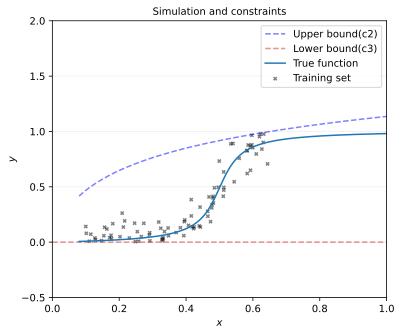

In [14]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train , y_train , s = 10, marker = 'x', color = 'black', alpha = 0.5,label='Training set')
plt.plot(x_test.numpy(),y_up.numpy(),color='blue', linestyle='--',alpha=0.5,label='Upper bound(c2)')
plt.axhline(y=0., color=c[3], linestyle='--',alpha=0.5,label='Lower bound(c3)')
plt.plot(x_test.numpy(),fun(x_test.numpy()),label='True function')


plt.xlim([0, 1])
plt.ylim([-0.5,2])
plt.xlabel('$x$', fontsize=10)
plt.ylabel('$y$', fontsize=10)

plt.title('Simulation and constraints', fontsize=10)
plt.tick_params(labelsize=10)
# plt.xticks(np.arange(-4, 5, 2))
plt.gca().yaxis.grid(alpha=0.2)
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(fun(x_test.numpy()),means)

0.0077820546